In [11]:
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import jupyter_black

jupyter_black.load()

# Load crypto data

In [23]:
def get_data():
    """
    Get the data from the csv file
    """

    df = pd.read_csv("crypto.csv")

    # only keep the columns we need
    df = df[["Symbol", "Date", "Close"]]

    # show all cryptocurrencies
    df["Symbol"].unique()

    # only keep BTC, ETH, BNB
    df = df[df["Symbol"].isin(["BTC", "ETH", "BNB", "Dogecoin"])]

    # check is there any missing data
    df.isnull().sum()

    # convert Date column to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # sort by date
    df = df.sort_values("Date")

    # groupby Symbol and check the number of days
    df.groupby("Symbol")["Date"].describe(datetime_is_numeric=True)

    # only keep the data from 2018-01-01 to 2021-06-01
    df = df[(df["Date"] >= "2018-01-01") & (df["Date"] <= "2021-06-01")]

    # each row is a cryptocurrency
    df = df.pivot(index="Date", columns="Symbol", values="Close")

    return df.values

In [13]:
def get_scaler(env):
    # return scikit-learn scaler object to scale the states
    # Note: you could also populate the replay buffer here

    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)
        state, reward, done, info = env.step(action)
        states.append(state)
        if done:
            break

    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [14]:
def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [15]:
class LinearModel:
    """A linear regression model"""

    def __init__(self, input_dim, n_action):
        self.W = np.random.randn(input_dim, n_action) / np.sqrt(input_dim)
        self.b = np.zeros(n_action)

        # momentum terms
        self.vW = 0
        self.vb = 0

        self.losses = []

    def predict(self, X):
        # make sure X is N x D (N sample size - how many obs we use, D state dimension - 7 in our case)
        assert (
            len(X.shape) == 2
        )  # assert is to chech if the condition is TRUE otherwise we have a warning error!
        return X.dot(self.W) + self.b

    def sgd(self, X, Y, learning_rate=0.01, momentum=0.9):
        # make sure X is N x D
        assert len(X.shape) == 2

        # X is the current Q(s,:)
        # Y is the target r + gamma max Q(s',:)
        # the loss values are 2-D
        # normally we would divide by N only
        # but now we divide by N x K - K is num_action, i.e. the number of outputs
        num_values = np.prod(Y.shape)

        # do one step of gradient descent
        # we multiply by 2 to get the exact gradient
        # (not adjusting the learning rate)
        # i.e. d/dx (x^2) --> 2x
        Yhat = self.predict(X)
        gW = (
            2 * X.T.dot(Yhat - Y) / num_values
        )  # here 2 is because of the derivative of the mean squared error \sum_{k=1}^n_action (y-yhat)^2
        gb = 2 * (Yhat - Y).sum(axis=0) / num_values

        # update momentum terms
        self.vW = momentum * self.vW - learning_rate * gW
        self.vb = momentum * self.vb - learning_rate * gb

        # update params
        self.W += self.vW
        self.b += self.vb

        mse = np.mean((Yhat - Y) ** 2)
        self.losses.append(mse)

    def load_weights(self, filepath):
        npz = np.load(filepath)
        self.W = npz["W"]
        self.b = npz["b"]

    def save_weights(self, filepath):
        np.savez(filepath, W=self.W, b=self.b)

In [16]:
class MultiStockEnv:
    """
    A 3-crypto trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
      - # shares of stock 1 owned
      - # shares of stock 2 owned
      - # shares of stock 3 owned
      - price of stock 1 (using daily close price)
      - price of stock 2
      - price of stock 3
      - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
      - for each stock, you can:
      - 0 = sell
      - 1 = hold
      - 2 = buy
    """

    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(
            map(list, itertools.product([0, 1, 2], repeat=self.n_stock))
        )

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()

    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()

    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {"cur_val": cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[: self.n_stock] = self.stock_owned
        obs[self.n_stock : 2 * self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs

    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = []  # stores index of stocks we want to sell
        buy_index = []  # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
            # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            # NOTE: when buying, we will loop through each stock we want to buy,
            #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1  # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [17]:
class DQNAgent(object):
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # D
        self.action_size = action_size  # num_action or K before
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = LinearModel(state_size, action_size)

    def act(self, state):  # epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(
            act_values[0]
        )  # returns action - 0 because here we have just N = 1 observation

    def train(self, state, action, reward, next_state, done):
        if done:
            target = reward  # terminal state
        else:
            target = reward + self.gamma * np.amax(
                self.model.predict(next_state), axis=1
            )  # any other state, this is r + \gamma Q(s',a')

        target_full = self.model.predict(state)  # this is Q(s,:)
        target_full[0, action] = target  # here we consider only Q(s,a)

        # Run one training step
        self.model.sgd(
            state, target_full
        )  # gradient descent method: we update only Q(s,a) -> for action a

        if self.epsilon > self.epsilon_min:
            self.epsilon *= (
                self.epsilon_decay
            )  # update of the \epsilon for learning -> decreasing in time

    def load(self, name):
        self.model.load_weights(name)  # we load W and b

    def save(self, name):
        self.model.save_weights(
            name
        )  # we save the new W and b - it is useful if we want to test some particula W and b at specific time

In [18]:
def play_one_episode(agent, env, is_train):
    # note: after transforming states are already 1xD
    # env is used to call the class "MultiStockEnv"
    state = env.reset()
    state = scaler.transform([state])
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if is_train == "train":
            agent.train(state, action, reward, next_state, done)
        state = next_state

    return info["cur_val"]

episode: 1/2000, episode end value: 23716.78, duration: 0:00:00.090807
episode: 2/2000, episode end value: 106978.09, duration: 0:00:00.178857
episode: 3/2000, episode end value: 78501.08, duration: 0:00:00.219611
episode: 4/2000, episode end value: 20916.67, duration: 0:00:00.073635
episode: 5/2000, episode end value: 25879.74, duration: 0:00:00.086834
episode: 6/2000, episode end value: 167913.62, duration: 0:00:00.295784
episode: 7/2000, episode end value: 37209.20, duration: 0:00:00.069246
episode: 8/2000, episode end value: 32842.14, duration: 0:00:00.096225
episode: 9/2000, episode end value: 19854.15, duration: 0:00:00.693494
episode: 10/2000, episode end value: 29251.85, duration: 0:00:00.647034
episode: 11/2000, episode end value: 12040.91, duration: 0:00:00.157959
episode: 12/2000, episode end value: 8577.31, duration: 0:00:00.137644
episode: 13/2000, episode end value: 87774.76, duration: 0:00:00.258012
episode: 14/2000, episode end value: 78856.37, duration: 0:00:00.319487


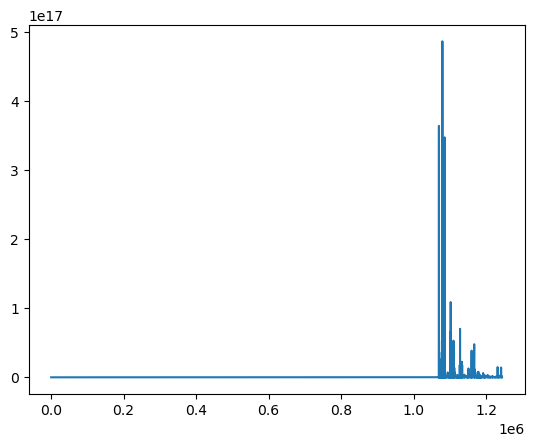

In [24]:
if __name__ == "__main__":

    # config
    models_folder = "linear_rl_trader_models"
    rewards_folder = "linear_rl_trader_rewards"
    num_episodes = 2000
    batch_size = 32  # unuseful here - batch size for sampling
    initial_investment = 50000

    mode = "train"

    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)

    data = get_data()
    n_timesteps, n_stocks = data.shape

    n_train = n_timesteps // 2

    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    # store the final value of the portfolio (end of episode)
    portfolio_value = []

    if mode == "test":
        # then load the previous scaler
        with open(f"{models_folder}/scaler.pkl", "rb") as f:
            scaler = pickle.load(f)

        # here for test we download the scaler -> we use the mean and std estimated on training set!

        # remake the env with test data
        env = MultiStockEnv(test_data, initial_investment)

        # make sure epsilon is not 1!
        # no need to run multiple episodes if epsilon = 0, it's deterministic
        agent.epsilon = 0.01

        # load trained weights
        agent.load(f"{models_folder}/linear.npz")

    # play the game num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()  # the time to measure the duration of each episode
        val = play_one_episode(agent, env, mode)
        dt = datetime.now() - t0
        print(
            f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}"
        )  # we print times for each episode
        portfolio_value.append(val)  # append episode end portfolio value

    # save the weights when we are done
    if mode == "train":
        # save the DQN
        agent.save(f"{models_folder}/linear.npz")

        # save the scaler
        with open(f"{models_folder}/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

        # plot losses
        plt.plot(agent.model.losses)
        plt.show()

    # save portfolio value for each episode
    np.save(f"{rewards_folder}/{mode}.npy", portfolio_value)

In [20]:
if __name__ == "__main__":

    # config
    models_folder = "linear_rl_trader_models"
    rewards_folder = "linear_rl_trader_rewards"
    num_episodes = 2000
    batch_size = 32  # unuseful here - batch size for sampling
    initial_investment = 50000

    mode = "test"

    maybe_make_dir(models_folder)
    maybe_make_dir(rewards_folder)

    data = get_data()
    n_timesteps, n_stocks = data.shape

    n_train = n_timesteps // 2

    train_data = data[:n_train]
    test_data = data[n_train:]

    env = MultiStockEnv(train_data, initial_investment)
    state_size = env.state_dim
    action_size = len(env.action_space)
    agent = DQNAgent(state_size, action_size)
    scaler = get_scaler(env)

    # store the final value of the portfolio (end of episode)
    portfolio_value = []

    if mode == "test":
        # then load the previous scaler
        with open(f"{models_folder}/scaler.pkl", "rb") as f:
            scaler = pickle.load(f)

        # here for test we download the scaler -> we use the mean and std estimated on training set!

        # remake the env with test data
        env = MultiStockEnv(test_data, initial_investment)

        # make sure epsilon is not 1!
        # no need to run multiple episodes if epsilon = 0, it's deterministic
        agent.epsilon = 0.01

        # load trained weights
        agent.load(f"{models_folder}/linear.npz")

    # play the game num_episodes times
    for e in range(num_episodes):
        t0 = datetime.now()  # the time to measure the duration of each episode
        val = play_one_episode(agent, env, mode)
        dt = datetime.now() - t0
        print(
            f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}"
        )  # we print times for each episode
        portfolio_value.append(val)  # append episode end portfolio value

    # save the weights when we are done
    if mode == "train":
        # save the DQN
        agent.save(f"{models_folder}/linear.npz")

        # save the scaler
        with open(f"{models_folder}/scaler.pkl", "wb") as f:
            pickle.dump(scaler, f)

        # plot losses
        plt.plot(agent.model.losses)
        plt.show()

    # save portfolio value for each episode
    np.save(f"{rewards_folder}/{mode}.npy", portfolio_value)

episode: 1/2000, episode end value: 738476.19, duration: 0:00:00.027669
episode: 2/2000, episode end value: 614924.40, duration: 0:00:00.031471
episode: 3/2000, episode end value: 498856.49, duration: 0:00:00.025149
episode: 4/2000, episode end value: 741234.90, duration: 0:00:00.025583
episode: 5/2000, episode end value: 583783.33, duration: 0:00:00.027157
episode: 6/2000, episode end value: 775260.01, duration: 0:00:00.026838
episode: 7/2000, episode end value: 728178.87, duration: 0:00:00.027714
episode: 8/2000, episode end value: 572884.67, duration: 0:00:00.027369
episode: 9/2000, episode end value: 733924.74, duration: 0:00:00.029150
episode: 10/2000, episode end value: 734986.57, duration: 0:00:00.029578
episode: 11/2000, episode end value: 682848.71, duration: 0:00:00.026294
episode: 12/2000, episode end value: 458951.53, duration: 0:00:00.027198
episode: 13/2000, episode end value: 687094.10, duration: 0:00:00.033521
episode: 14/2000, episode end value: 594658.27, duration: 0: